##### Copyright 2019 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Custom Federated Algorithms, Part 2: Implementing Federated Averaging

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/federated/tutorials/custom_federated_algorithms_2"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/federated/blob/v0.4.0/docs/tutorials/custom_federated_algorithms_2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/federated/blob/v0.4.0/docs/tutorials/custom_federated_algorithms_2.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This tutorial is the second part of a two-part series that demonstrates how to
implement custom types of federated algorithms in TFF using the
[Federated Core (FC)](../federated_core.md), which serves as a foundation for
the [Federated Learning (FL)](../federated_learning.md) layer (`tff.learning`).

We encourage you to first read the
[first part of this series](custom_federated_algorithms_1.ipynb), which
introduce some of the key concepts and programming abstractions used here.

This second part of the series uses the mechanisms introduced in the first part
to implement a simple version of federated training and evaluation algorithms.

We encourage you to review the
[image classification](federated_learning_for_image_classification.ipynb) and
[text generation](federated_learning_for_text_generation.ipynb) tutorials for a
higher-level and more gentle introduction to TFF's Federated Learning APIs, as
they will help you put the concepts we describe here in context.

## Before we start

Before we start, try to run the following "Hello World" example to make sure
your environment is correctly setup. If it doesn't work, please refer to the
[Installation](../install.md) guide for instructions.

In [1]:
#@test {"skip": true}

# NOTE: If you are running a Jupyter notebook, and installing a locally built
# pip package, you may need to edit the following to point to the '.whl' file
# on your local filesystem.

#!pip install tensorflow_federated

In [3]:
from __future__ import absolute_import, division, print_function

import collections
import numpy as np
from six.moves import range
import tensorflow as tf
import datetime

from tensorflow_federated import python as tff

tf.compat.v1.enable_v2_behavior()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [4]:
@tff.federated_computation
def hello_world():
  return 'Hello, World!'


hello_world()

'Hello, World!'

## Implementing Federated Averaging

As in
[Federated Learning for Image Classification](federated_learning_for_image_classification.md),
we are going to use the MNIST example, but since this is intended as a low-level
tutorial, we are going to bypass the Keras API and `tff.simulation`, write raw
model code, and construct a federated data set from scratch.



### Preparing federated data sets

For the sake of a demonstration, we're going to simulate a scenario in which we
have data from 10 users, and each of the users contributes knowledge how to
recognize a different digit. This is about as
non-[i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables)
as it gets.

First, let's load the standard MNIST data:

In [214]:
#@test {"output": "ignore"}
cifar_train, cifar_test = tf.keras.datasets.cifar10.load_data()
mnist_train, mnist_test = tf.keras.datasets.mnist.load_data()
cifar_class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [30]:
cifar_test = [x[:2000] for x in cifar_test]

In [31]:
[x.shape for x in cifar_train]

[(50000, 32, 32, 3), (50000, 1)]

In [32]:
[x.shape for x in cifar_test]

[(2000, 32, 32, 3), (2000, 1)]

The data comes as Numpy arrays, one with images and another with digit labels, both
with the first dimension going over the individual examples. Let's write a
helper function that formats it in a way compatible with how we feed federated
sequences into TFF computations, i.e., as a list of lists - the outer list
ranging over the users (digits), the inner ones ranging over batches of data in
each client's sequence. As is customary, we will structure each batch as a pair
of tensors named `x` and `y`, each with the leading batch dimension. While at
it, we'll also flatten each image into a 784-element vector and rescale the
pixels in it into the `0..1` range, so that we don't have to clutter the model
logic with data conversions.

In [238]:
NUM_EXAMPLES_PER_USER = 2000
BATCH_SIZE = 32
USERS = 5
NUM_EPOCHS = 1
CLASSES = 10

# def get_indices_unbalanced(y):
#     # split dataset into arrays of each class label
#     indices_array = []
#     for c in range(CLASSES):
#         indices_array.append([i for i, d in enumerate(y) if d == c])
#     class_shares = CLASSES // min(CLASSES, USERS)
#     user_indices = []
#     for u in range(USERS):
#         user_indices.append(
#             np.array(
#                 [indices_array.pop(0)[:NUM_EXAMPLES_PER_USER//class_shares] for j in range(class_shares)])
#             .flatten())
#     return user_indices

def get_indices_unbalanced(y):
    # split dataset into arrays of each class label
    indices_array = []
    for c in range(CLASSES):
        indices_array.append([i for i, d in enumerate(y) if d == c])
    # each user will have 2 classes excluded from their data sets, thus 250 examples * remaining 8 classes
    class_shares = 250
    # store indices for future use
    user_indices = []
    # auxilary index array to pop out pairs of classes missing at each user
    class_index = list(range(CLASSES))
    for u in range(USERS):
        columns_out = [class_index.pop(0) for i in range(2)]
        selected_columns = set(range(CLASSES)) - set(columns_out)
        starting_index = u*class_shares
        user_indices.append(
            np.array(indices_array)[list(selected_columns)].T[starting_index:starting_index + class_shares]
            .flatten())
    return user_indices

def get_indices_even(y):
    # split dataset into arrays of each class label
    indices_array = []
    for c in range(CLASSES):
        indices_array.append([i for i, d in enumerate(y) if d == c])
    user_indices = []
    class_shares = NUM_EXAMPLES_PER_USER // CLASSES
    
    # take even shares of each class for every user
    for u in range(USERS):
        starting_index = u*class_shares
        user_indices.append(np.array(indices_array).T[starting_index:starting_index + class_shares].flatten())   
    return user_indices

def get_non_distributed(source):
    indices = np.concatenate(get_indices_even(source[1]))
    y = np.array(source[1][[indices]], dtype=np.int32)
    X = np.array(source[0][[indices]], dtype=np.float32) / 255.0
    return X, y
    
def get_distributed(source, u, distribution):
    if distribution == 'iid':
        indices = get_indices_even(source[1])[u]
    else:
        indices = get_indices_unbalanced(source[1])[u]
    output_sequence = []
    for repeat in range(NUM_EPOCHS):
        for i in range(0, len(indices), BATCH_SIZE):
            batch_samples = indices[i:i + BATCH_SIZE]
            output_sequence.append({
                'x': np.array([source[0][b] / 255.0 for b in batch_samples], dtype=np.float32),
                'y': np.array([source[1][b] for b in batch_samples], dtype=np.int32)})
    return output_sequence


federated_train_data = [get_distributed(cifar_train, u, 'non-iid') for u in range(USERS)]
federated_test_data = [get_distributed(cifar_test, u, 'non-iid') for u in range(USERS)]

(X, y) = get_non_distributed(cifar_train)
(X_test, y_test) = get_non_distributed(cifar_test)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [237]:
indices_array = []
for c in range(CLASSES):
    indices_array.append([i for i, d in enumerate(cifar_train[1]) if d == c])
class_index = list(range(CLASSES))
user_indices = []
for u in range(5):
    class_shares = NUM_EXAMPLES_PER_USER // (CLASSES - 2)
    columns_out= [class_index.pop(0) for i in range(2)]
    selected_columns = set(range(CLASSES)) - set(columns_out)
    starting_index = u*class_shares
    user_indices.append(
        np.array(indices_array)[list(selected_columns)].T[starting_index:starting_index + class_shares]
        .flatten())
len(user_indices[2])

2000

In [239]:
indices = get_indices_unbalanced(cifar_train[1])
len(indices[0])

2000

In [241]:
len(federated_train_data[1])

63

In [30]:
# features = len(federated_train_data[0][0]['x'][1])
# features

32

In [242]:
sample_batch = federated_train_data[1][-2]
sample_batch['x'].shape

(32, 32, 32, 3)

As a quick sanity check, let's look at the `Y` tensor in the last batch of data
contributed by the fifth client (the one corresponding to the digit `5`).

Just to be sure, let's also look at the image corresponding to the last element of that batch.

ship


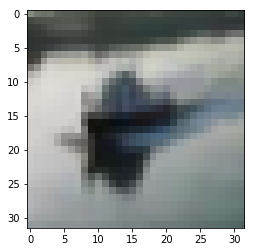

In [196]:
#@test {"output": "ignore"}
from matplotlib import pyplot as plt
%matplotlib inline
print(cifar_class_labels[federated_train_data[4][5]['y'][-5][0]])
plt.imshow(federated_train_data[4][5]['x'][-5].reshape(32, 32, 3))
#plt.imshow(cifar_train[0][4])
plt.grid(False)
plt.show()

# Creating a model with Keras

In [243]:
WIDTH = 32
HEIGHT = 32
CHANNELS = 3

from tensorflow.python.keras.optimizer_v2 import gradient_descent
from tensorflow.keras import layers

def create_compiled_keras_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(
            32,
            (3, 3),
            activation="tanh",
            padding="same",
            input_shape=(WIDTH, HEIGHT, CHANNELS)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation="tanh", padding="same"),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Flatten(), 
        tf.keras.layers.Dense(128, activation="tanh"),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)])
    
    def loss_fn(y_true, y_pred):
        return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(
        y_true, y_pred))
    
    model.compile(
      loss=loss_fn,
      optimizer="adam",
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
    return model

# Non-federated keras model

In [8]:
non_federated_model = create_compiled_keras_model()

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
history_callback = non_federated_model.fit(X, y, validation_data=(X_test, y_test), batch_size=32, epochs=24)

Train on 10000 samples, validate on 10000 samples
Epoch 1/24
10000/10000 [==============================] - 15s 1ms/sample - loss: 1.6382 - sparse_categorical_accuracy: 0.4147 - val_loss: 1.5104 - val_sparse_categorical_accuracy: 0.4542
Epoch 2/24
10000/10000 [==============================] - 16s 2ms/sample - loss: 1.2800 - sparse_categorical_accuracy: 0.5523 - val_loss: 1.2884 - val_sparse_categorical_accuracy: 0.5481
Epoch 3/24
10000/10000 [==============================] - 15s 1ms/sample - loss: 1.0808 - sparse_categorical_accuracy: 0.6217 - val_loss: 1.2068 - val_sparse_categorical_accuracy: 0.5814
Epoch 4/24
10000/10000 [==============================] - 14s 1ms/sample - loss: 0.9421 - sparse_categorical_accuracy: 0.6750 - val_loss: 1.2103 - val_sparse_categorical_accuracy: 0.5909
Epoch 5/24
10000/10000 [==============================] - 15s 2ms/sample - loss: 0.8022 - sparse_categorical_accuracy: 0.7211 - val_loss: 1.2788 - val_sparse_categorical_accuracy: 0.5842
Epoch 6/24
1000

In [10]:
test_accuracy = history_callback.history['loss'].
test_accuracy

[1.655926287460327,
 1.2823033974647522,
 1.0880563432693482,
 0.9493140579223632,
 0.7874517530441284,
 0.658087611579895,
 0.5073754133224487,
 0.36487327415943144,
 0.24285174493789674,
 0.14969820445775986,
 0.08320909231901169,
 0.046573911333084105]

In [163]:
len(non_federated_model.get_weights())
non_federated_model.predict(X_test)[0]

array([2.5023393e-02, 1.8679442e-05, 3.9345308e-04, 2.1132200e-08,
       5.1386255e-06, 1.3187279e-10, 1.1822884e-08, 1.0433977e-08,
       9.7455931e-01, 3.1568486e-08], dtype=float32)

In [10]:
try:
    with open('Log/Exp2/'+ datetime.datetime.now().strftime("%y-%m-%d-%H-%M")+'.txt', 'w') as log:
        print("Cifar10, Non-federated, IDD, minibatch_size: 32", file=log)
        print("Train Loss: {}".format(history_callback.history["loss"]), file=log)
        print("Test Accuracy: {}".format(history_callback.history["val_sparse_categorical_accuracy"]), file=log)
                
except IOError:
    print('File Error')

In [107]:
def model_fn():
    keras_model = create_compiled_keras_model()
    return tff.learning.from_compiled_keras_model(keras_model, sample_batch)

In [108]:
#@test {"output": "ignore"}
iterative_process = tff.learning.build_federated_averaging_process(model_fn)

In [109]:
evaluation = tff.learning.build_federated_evaluation(model_fn)

In [110]:
# One round / one user test
state = iterative_process.initialize()
state, metrics = iterative_process.next(state, federated_train_data[0:1])
test_metrics = evaluation(state.model, federated_test_data)
print('round  1, metrics={}'.format(metrics))
print('test accuracy: {}'.format(test_metrics.sparse_categorical_accuracy))

round  1, metrics=<sparse_categorical_accuracy=0.9095,loss=0.70365334>
test accuracy: 0.10000000149011612


In [39]:
#@test {"skip": true}
state = iterative_process.initialize()
fd_test_accuracy = []
fd_train_loss = []
for round_num in range(12):
    selected = np.random.choice(5, 4, replace=False)
    state, metrics = iterative_process.next(state, list(np.array(federated_train_data)[selected]))
    test_metrics = evaluation(state.model, federated_test_data)
    fd_train_loss.append(metrics[1])
    fd_test_accuracy.append(test_metrics.sparse_categorical_accuracy)
    print('round {:2d}, metrics={}'.format(round_num, metrics))

round  0, metrics=<sparse_categorical_accuracy=0.324125,loss=1.9001744>
round  1, metrics=<sparse_categorical_accuracy=0.419125,loss=1.6454167>
round  2, metrics=<sparse_categorical_accuracy=0.46125,loss=1.5224783>
round  3, metrics=<sparse_categorical_accuracy=0.50075,loss=1.4221473>
round  4, metrics=<sparse_categorical_accuracy=0.523125,loss=1.3453794>
round  5, metrics=<sparse_categorical_accuracy=0.552,loss=1.2697442>
round  6, metrics=<sparse_categorical_accuracy=0.57225,loss=1.2189674>
round  7, metrics=<sparse_categorical_accuracy=0.59275,loss=1.1593635>
round  8, metrics=<sparse_categorical_accuracy=0.613875,loss=1.108856>
round  9, metrics=<sparse_categorical_accuracy=0.63075,loss=1.069857>
round 10, metrics=<sparse_categorical_accuracy=0.64825,loss=1.0136998>
round 11, metrics=<sparse_categorical_accuracy=0.6655,loss=0.9766627>


In [145]:
state.model.trainable

(10,)

In [30]:
selected = np.random.choice(5, 4, replace=False)
len(list(np.array(federated_train_data)[selected]))

4

In [41]:
try:
    with open('Log/Exp3/'+ datetime.datetime.now().strftime("%y-%m-%d-%H-%M")+'.txt', 'w') as log:
        print("Cifar10, Federated E1C4, IDD, minibatch_size: 32", file=log)
        print("Train Loss: {}".format(fd_train_loss), file=log)
        print("Test Accuracy: {}".format(fd_test_accuracy), file=log)
                
except IOError:
    print('File Error')

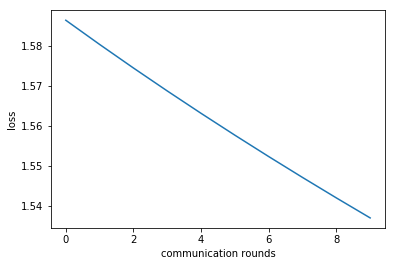

In [383]:
# plot the cost
plt.plot(np.squeeze(loss))
plt.ylabel('loss')
plt.xlabel('communication rounds')
#plt.title("Learning rate =" + str(learning_rate))
plt.show()